In [1]:
print("""
EcoPackAI – Data Cleaning, Validation & Merging
==============================================

Chronological pipeline:
1. Load raw datasets
2. Inspect schema (head / info / describe)
3. Select required columns
4. Clean individual datasets
5. Resolve material identity (ID only)
6. Merge history with materials (single source of truth)
7. Detect missing materials post-merge
8. Inject canonical material properties
9. Save clean + final datasets
""")


EcoPackAI – Data Cleaning, Validation & Merging

Chronological pipeline:
1. Load raw datasets
2. Inspect schema (head / info / describe)
3. Select required columns
4. Clean individual datasets
5. Resolve material identity (ID only)
6. Merge history with materials (single source of truth)
7. Detect missing materials post-merge
8. Inject canonical material properties
9. Save clean + final datasets



### Import Libraries

In [2]:
# ======================================================
# IMPORTS
# ======================================================

import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt

### Define DataPaths

In [3]:
# ======================================================
# PATH CONFIG (RELATIVE, REPO-INDEPENDENT)
# ======================================================

RAW_MATERIALS_PATH = r"../data/raw/materials_database_600.xlsx"
RAW_HISTORY_PATH   = r"../data/raw/real_packaging_history.xlsx"

CLEAN_MATERIALS_PATH = r"../data/processed/clean_materials.csv"
CLEAN_HISTORY_PATH   = r"../data/processed/clean_history.csv"
FINAL_DATASET_PATH   = r"../data/processed/final_ecopack_dataset.csv"
LOOKUP_PATH          = r"../data/processed/material_id_lookup.csv"

# ======================================================
# LOGGING HEADER
# ======================================================

print("=" * 70)
print("EcoPackAI – Data Cleaning & Merging")
print("Started:", datetime.now())
print("=" * 70)

EcoPackAI – Data Cleaning & Merging
Started: 2026-01-14 01:13:37.721912


### Load Materials and Packaging datasets

In [4]:
# ======================================================
# STEP 1: LOAD RAW DATA
# ======================================================

materials_df = pd.read_excel(RAW_MATERIALS_PATH)
history_df   = pd.read_excel(RAW_HISTORY_PATH)

print("\nSTEP 1: DATA LOADED")
print("Materials:", materials_df.shape)
print("History  :", history_df.shape)


STEP 1: DATA LOADED
Materials: (600, 8)
History  : (15000, 16)


### Perform Exploratory Data Analysis(EDA) 

In [5]:
# ======================================================
# STEP 2: INSPECTION
# ======================================================
print("\nSTEP 2: DATA INSPECTION")

print("\n--- Materials HEAD ---")
print(materials_df.head())

print("\n--- Materials COLUMNS ---")
print(materials_df.columns.tolist())

print("\n--- Materials INFO ---")
materials_df.info()

print("\n--- Materials DESCRIBE ---")
print(materials_df.describe())

print('\n')
print('='*50)
print('\n')

print("\n--- History HEAD ---")
print(history_df.head())

print("\n--- History COLUMNS ---")
print(history_df.columns.tolist())

print("\n--- History INFO ---")
history_df.info()

print("\n--- History DESCRIBE ---")
print(history_df.describe())

print('\n')


STEP 2: DATA INSPECTION

--- Materials HEAD ---
   Material_ID                Material_Name Category  Density_kg_m3  \
0            1           Recycled Palm Leaf      Eco            489   
1            2         Waterproof Palm Leaf      Eco            561   
2            3       Single-Ply Kraft Paper    Paper            742   
3            4     Single-Ply Aluminum Foil    Metal           2506   
4            5  Fire-Retardant Nylon Fabric  Plastic           1323   

   Tensile_Strength_MPa  CO2_Emission_kg  Cost_per_kg Biodegradable  
0                 13.19            0.235         1.06           Yes  
1                 15.29            0.449         1.47           Yes  
2                 36.08            0.742         0.91           Yes  
3                 32.48           11.137         3.30            No  
4                 69.04            6.800         4.71            No  

--- Materials COLUMNS ---
['Material_ID', 'Material_Name', 'Category', 'Density_kg_m3', 'Tensile_Streng

### Feature Selection
``` 1. Helps reduce noise, focus on meaningful features, and avoid unnecessary memory usage. ```

``` 2. Ensures that later steps like cleaning, mapping, and feature engineering are applied only on the required data. ```

In [6]:
# ======================================================
# STEP 3: COLUMN SELECTION (EXPLICIT & JUSTIFIED)
# ======================================================
print("\nSTEP 3: COLUMN SELECTION")

# ---- MATERIAL DATABASE ----
material_columns_to_keep = [
     'Material_ID',
     'Material_Name',
     'Category',                # Category_Material
     'Density_kg_m3',
     'Tensile_Strength_MPa',
     'Cost_per_kg',
     'CO2_Emission_kg',
     'Biodegradable'
]


# Select only existing columns
materials_df = materials_df[material_columns_to_keep]
print("✓ Selected material columns")

# ---- PACKAGING HISTORY ----
history_columns_to_keep = [
     'Category',               # Category_Product
     'Weight_kg',              # Weight_Product
     'Volumetric_Weight_kg',
     'L_cm', 
     'W_cm', 
     'H_cm',
     'Fragility',
     'Moisture_Sens',
     'Shipping_Mode',
     'Distance_km',
     'Packaging_Used',
     'Cost_USD',               # TARGET cost of packaging
     'CO2_Emission_kg'         # TARGET co2 emission in order shipment
]

# Select only existing columns
history_df = history_df[history_columns_to_keep]
print("✓ Selected history columns")


STEP 3: COLUMN SELECTION
✓ Selected material columns
✓ Selected history columns


### Data Cleaning

``` Produces clean datasets (materials_df and history_df) with no duplicates or nulls in key columns ```

In [7]:
# ======================================================
# STEP 4: DATA CLEANING
# ======================================================
print("\nSTEP 4: DATA CLEANING")

# ---- Remove duplicates ----
materials_df.drop_duplicates(inplace=True)
history_df.drop_duplicates(inplace=True)  

print("✓ Removed duplicates")

# ---- Handle missing values ----
# Check for nulls
print("\nMaterials null values:\n", materials_df.isnull().sum())
print("\nHistory null values:\n", history_df.isnull().sum())

# If needed, fill or drop (example)
materials_df.dropna(inplace=True)
history_df.dropna(inplace=True)

print("✓ Handled missing values")

print('\n')
print(f"materials_df shape : {materials_df.shape}")
print(f"history_df shape : {history_df.shape}")


STEP 4: DATA CLEANING
✓ Removed duplicates

Materials null values:
 Material_ID             0
Material_Name           0
Category                0
Density_kg_m3           0
Tensile_Strength_MPa    0
Cost_per_kg             0
CO2_Emission_kg         0
Biodegradable           0
dtype: int64

History null values:
 Category                0
Weight_kg               0
Volumetric_Weight_kg    0
L_cm                    0
W_cm                    0
H_cm                    0
Fragility               0
Moisture_Sens           0
Shipping_Mode           0
Distance_km             0
Packaging_Used          0
Cost_USD                0
CO2_Emission_kg         0
dtype: int64
✓ Handled missing values


materials_df shape : (600, 8)
history_df shape : (14999, 13)


### Fuzzy Match Packaging → Known Materials

In [8]:
# ======================================================
# STEP 5: FUZZY MATCH PACKAGING → MATERIAL_ID
# ======================================================
  
material_names = materials_df["Material_Name"].tolist()

def fuzzy_material_id(packaging, threshold=58):
    if not isinstance(packaging, str):
        return np.nan
    match, score, idx = process.extractOne(
        packaging, material_names, scorer=fuzz.token_sort_ratio
    )
    if score >= threshold:
        return materials_df.iloc[idx]["Material_ID"]
    return np.nan

history_df["Material_ID"] = history_df["Packaging_Used"].apply(fuzzy_material_id)

print("\nSTEP 4: FUZZY MATERIAL MATCHING COMPLETE")
print("Unmatched rows:", history_df["Material_ID"].isna().sum())


STEP 4: FUZZY MATERIAL MATCHING COMPLETE
Unmatched rows: 7533


### Identify Missing Materials

In [9]:
unmatched_mask = history_df["Material_ID"].isna()
unmatched_packages = history_df.loc[unmatched_mask, "Packaging_Used"].unique()
print(unmatched_packages)

['Mushroom Pkg (Mycelium)' 'Honeycomb Paper']


In [10]:
history_df.head()

,Category,Weight_kg,Volumetric_Weight_kg,L_cm,W_cm,H_cm,Fragility,Moisture_Sens,Shipping_Mode,Distance_km,Packaging_Used,Cost_USD,CO2_Emission_kg,Material_ID
0,Clothing,0.82,1.41,28,21,12,5,False,Air,1893,Kraft Paper Mailer,1.56,6.673,550.0
1,Electronics,0.29,0.00,14,7,0,9,True,Air,2141,Mushroom Pkg (Mycelium),1.92,1.552,NaN
2,Furniture,12.26,38.06,60,61,52,6,False,Road,1491,Wood Crate,16.42,28.374,405.0
3,Furniture,11.56,38.27,65,64,46,5,False,Road,530,Wood Crate,16.31,10.142,405.0
4,Clothing,0.25,0.08,22,18,1,1,False,Air,1587,Kraft Paper Mailer,0.30,0.992,550.0


In [11]:
for col in history_df.columns:
    if history_df[col].dtype == object:
        print(f"{col} : {history_df[col].unique()}")

Category : ['Clothing' 'Electronics' 'Furniture' 'Home Decor' 'Beauty']
Shipping_Mode : ['Air' 'Road']
Packaging_Used : ['Kraft Paper Mailer' 'Mushroom Pkg (Mycelium)' 'Wood Crate'
 'PLA Bioplastic' 'Honeycomb Paper' 'Recycled PET Box'
 'Bubble Wrap (LDPE)' 'Corrugated Cardboard' 'Styrofoam (EPS)'
 'Cornstarch Foam']


### Canonical Profiles

In [12]:
# ======================================================
# STEP 6: CANONICAL PROFILES FOR UNKNOWN MATERIALS
# ======================================================

material_profiles = {
    "Mushroom Pkg (Mycelium)": {
        "Material_ID": "601",
        "Material_Name": "Mushroom Pkg (Mycelium)",
        "Category": "Bio-based",
        "Density_kg_m3": 95,              # very lightweight foam-like
        "Tensile_Strength_MPa": 12.0,
        "Cost_per_kg": 3.20,
        "CO2_Emission_kg": 0.18,
        "Biodegradable": "Yes"
    },

    "Honeycomb Paper": {
        "Material_ID": "602",
        "Material_Name": "Honeycomb Paper",
        "Category": "Paper",
        "Density_kg_m3": 380,             # structured paper
        "Tensile_Strength_MPa": 42.0,
        "Cost_per_kg": 1.95,
        "CO2_Emission_kg": 0.75,
        "Biodegradable": "Yes"
    }
}

In [13]:
# Make a list of dicts for each profile
canonical_rows = []
for pkg_name, profile in material_profiles.items():
    row = {
        "Material_ID": 601 if pkg_name == "Mushroom Pkg (Mycelium)" else 602,
        "Material_Name": profile["Material_Name"],
        "Category": profile["Category"],
        "Density_kg_m3": profile["Density_kg_m3"],
        "Tensile_Strength_MPa": profile["Tensile_Strength_MPa"],
        "Cost_per_kg": profile["Cost_per_kg"],
        "CO2_Emission_kg": profile["CO2_Emission_kg"],
        "Biodegradable": profile["Biodegradable"]
    }
    canonical_rows.append(row)

# Convert list of dicts to DataFrame
canonical_df = pd.DataFrame(canonical_rows)

# Append to materials_df
materials_df = pd.concat([materials_df, canonical_df], ignore_index=True)

print("\nSTEP 11: CANONICAL MATERIAL PROFILES APPENDED TO materials_df")
print("New materials_df shape:", materials_df.shape)


STEP 11: CANONICAL MATERIAL PROFILES APPENDED TO materials_df
New materials_df shape: (602, 8)


In [14]:
# Save modified materials dataset
materials_df.to_csv(CLEAN_MATERIALS_PATH, index=False)

### Assigning Resolved Material IDs 

In [15]:
unresolved_packaging = (
    history_df.loc[history_df["Material_ID"].isna(), "Packaging_Used"]
    .dropna()
    .unique()
)

print(unresolved_packaging)

['Mushroom Pkg (Mycelium)' 'Honeycomb Paper']


In [16]:
# ======================================================
# STEP 7: RESOLVE MATERIAL IDs 
# ======================================================

# Material_ID for not registered materials
# "Mushroom Pkg (Mycelium)": 601
#         "Honeycomb Paper": 602

history_df.loc[
    history_df["Packaging_Used"] == "Mushroom Pkg (Mycelium)",
    "Material_ID"
] = 601

history_df.loc[
    history_df["Packaging_Used"] == "Honeycomb Paper",
    "Material_ID"
] = 602

### Save the clean datasets 

In [17]:
# ======================================================
# STEP 8: SAVE CLEAN HISTORY + LOOKUP
# ======================================================

# 1️⃣ Save cleaned history dataset
history_df.to_csv(CLEAN_HISTORY_PATH, index=False)

# 2️⃣ Build packaging → material lookup (authoritative)
packaging_material_cache = (
    history_df
    .dropna(subset=["Material_ID"])
    .groupby("Packaging_Used")["Material_ID"]
    .first()
    .to_dict()
)

# 3️⃣ Save lookup as a CSV (human-readable, auditable)
lookup_df = (
    history_df[["Packaging_Used", "Material_ID"]]
    .drop_duplicates()
    .sort_values("Material_ID")
)

lookup_df.to_csv(LOOKUP_PATH, index=False)

print("\nSTEP 8: CLEAN HISTORY & LOOKUP SAVED SUCCESSFULLY")


STEP 8: CLEAN HISTORY & LOOKUP SAVED SUCCESSFULLY


### Visualizing Packaging Usage

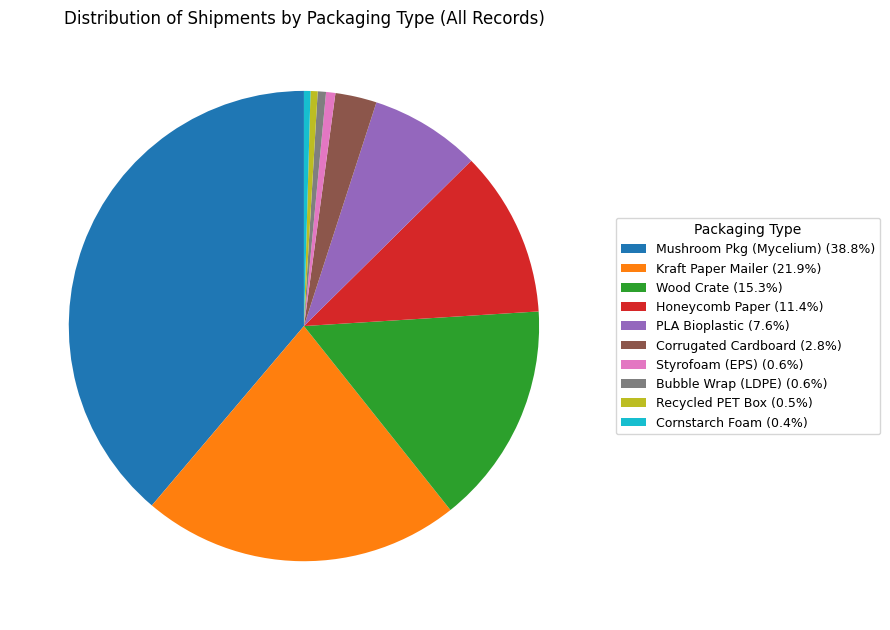

In [18]:
# Count packaging usage
packaging_counts = history_df["Packaging_Used"].value_counts()

labels = packaging_counts.index.tolist()
sizes = packaging_counts.values
total = sizes.sum()

# Generate percentages for legend text
legend_labels = [
    f"{label} ({(count / total) * 100:.1f}%)"
    for label, count in zip(labels, sizes)
]

plt.figure(figsize=(9, 9))

# Draw pie WITHOUT labels (clean look)
wedges, _ = plt.pie(
    sizes,
    startangle=90
)

# Legend uses SAME wedges → automatic color mapping
plt.legend(
    wedges,
    legend_labels,
    title="Packaging Type",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=9
)

plt.title("Distribution of Shipments by Packaging Type (All Records)")
plt.tight_layout()
plt.show()

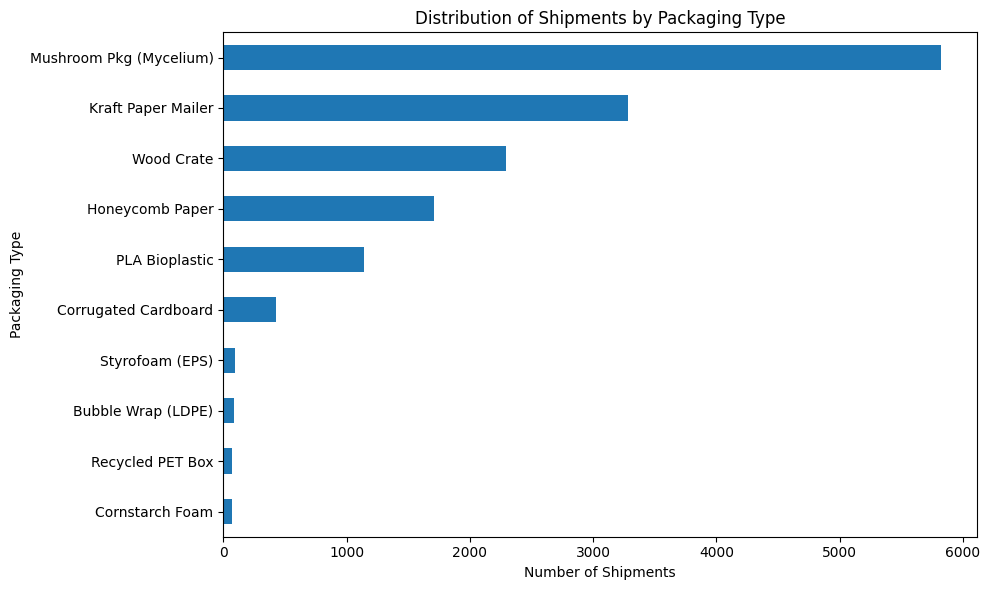

In [19]:
plt.figure(figsize=(10, 6))

packaging_counts.sort_values().plot(
    kind="barh"
)

plt.xlabel("Number of Shipments")
plt.ylabel("Packaging Type")
plt.title("Distribution of Shipments by Packaging Type")
plt.tight_layout()
plt.show()

### Merge materials and package history datasets on Material ID column

In [20]:
# ======================================================
# STEP 9: MERGE HISTORY WITH MATERIALS
# ======================================================

final_df = pd.merge(
    history_df,
    materials_df,
    on="Material_ID",
    how="left",
    suffixes=("_item", "_material")
)

print("\nSTEP 9: DATA MERGED")
print("Final shape:", final_df.shape)


STEP 9: DATA MERGED
Final shape: (14999, 21)


In [21]:
pd.set_option("display.max_columns", None)

In [22]:
final_df.head()

,Category_item,Weight_kg,Volumetric_Weight_kg,L_cm,W_cm,H_cm,Fragility,Moisture_Sens,Shipping_Mode,Distance_km,Packaging_Used,Cost_USD,CO2_Emission_kg_item,Material_ID,Material_Name,Category_material,Density_kg_m3,Tensile_Strength_MPa,Cost_per_kg,CO2_Emission_kg_material,Biodegradable
0,Clothing,0.82,1.41,28,21,12,5,False,Air,1893,Kraft Paper Mailer,1.56,6.673,550.0,Laminated Kraft Paper,Paper,868,59.17,1.52,1.026,Yes
1,Electronics,0.29,0.00,14,7,0,9,True,Air,2141,Mushroom Pkg (Mycelium),1.92,1.552,601.0,Mushroom Pkg (Mycelium),Bio-based,95,12.00,3.20,0.180,Yes
2,Furniture,12.26,38.06,60,61,52,6,False,Road,1491,Wood Crate,16.42,28.374,405.0,Recycled Pine Wood Crate,Wood,484,30.47,1.74,0.290,Yes
3,Furniture,11.56,38.27,65,64,46,5,False,Road,530,Wood Crate,16.31,10.142,405.0,Recycled Pine Wood Crate,Wood,484,30.47,1.74,0.290,Yes
4,Clothing,0.25,0.08,22,18,1,1,False,Air,1587,Kraft Paper Mailer,0.30,0.992,550.0,Laminated Kraft Paper,Paper,868,59.17,1.52,1.026,Yes


In [23]:
final_df.columns.tolist()

['Category_item',
 'Weight_kg',
 'Volumetric_Weight_kg',
 'L_cm',
 'W_cm',
 'H_cm',
 'Fragility',
 'Moisture_Sens',
 'Shipping_Mode',
 'Distance_km',
 'Packaging_Used',
 'Cost_USD',
 'CO2_Emission_kg_item',
 'Material_ID',
 'Material_Name',
 'Category_material',
 'Density_kg_m3',
 'Tensile_Strength_MPa',
 'Cost_per_kg',
 'CO2_Emission_kg_material',
 'Biodegradable']

### Save the final Dataset

In [24]:
# ======================================================
# STEP 12: SAVE FINAL DATASET
# ======================================================

final_df.to_csv(FINAL_DATASET_PATH, index=False)

print("=" * 70)
print("✓ DATA CLEANING & MERGING COMPLETE")
print("Final shape:", final_df.shape)
print("=" * 70)

✓ DATA CLEANING & MERGING COMPLETE
Final shape: (14999, 21)
